# Class code for Comparison Study of Outlier Detection
> 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연

|Method|Category|JIT Enabled|Multicore|Citation number|
|:--|:--:|:--:|:--:|:--:|
|LOF (Breunig et al., 2000)|Proximity|No|Yes||
|kNN (Ramaswamy et al., 2000)|Proximity|No|Yes||
|AvgkNN (Angiulli and Pizzuti, 2002)|Proximity|No|Yes||
|CBLOF (He et al., 2003)|Proximity|Yes|No||
|OCSVM (Sch ̈olkopf et al., 2001)|Linear Model|No|No||
|LOCI (Papadimitriou et al., 2003)|Proximity|Yes|No|1157|
|PCA (Shyu et al., 2003)|Linear Model|No|No||
|MCD (Hardin and Rocke, 2004)|Linear Model|No|No||
|Feature Bagging (Lazarevic and Kumar, 2005)|Ensembling|No|Yes|705|
|ABOD (Kriegel et al., 2008)|Proximity|Yes|No|884|
|Isolation Forest (Liu et al., 2008)|Ensembling|No|Yes||
|HBOS (Goldstein and Dengel, 2012)|Proximity|Yes|No||
|SOS (Janssens et al., 2012)|Proximity|Yes|No||
|AutoEncoder (Sakurada and Yairi, 2014)|Neural Net|Yes|No||
|AOM (Aggarwal and Sathe, 2015)|Ensembling|No|No||
|MOA (Aggarwal and Sathe, 2015)|Ensembling|No|No||
|SO-GAAL (Liu et al., 2019)|Neural Net|No|No||
|MO-GAAL (Liu et al., 2019)|Neural Net|No|No||
|XGBOD (Zhao and Hryniewicki, 2018b)|Ensembling|No|Yes|93|
|LSCP (Zhao et al., 2019)|Ensembling|No|No|97|

---

다른 논문 the stanford bunny 소개하는 법
1. A DNA-of-things storage architecture to create materials with embedded memory
- we selected the Stanford Bunny9, which is a common computer graphics 3D test model. 

2. Pop-up print: Rapidly 3D printing mechanically reversible objects in the folded state
- In addition to the constraints discussed in the previous section, general 3D shapes, such as the Stanford Bunny, tend to have fewer tapered regions.

3. An Integrating Approach to Meshing Scattered Point Data
- The finest bunny (76K triangles) contains details missed in the standard Stanford bunny mesh generated by zippering the bunny scans [Turk and Levoy 1994].

---

The Stanford Bunny

The Stanford Bunny is one of the most commonly used test models in computer graphics. It is a collection of 69,451 triangles, and it was assembled from range images of a clay bunny that is roughly 7.5 inches high. Below is a synthetic rendering of the model, courtesy of Peter Lindstrom. This Web page describes where the model came from, tells why it was created in the first place, discusses the relative merits of using it as a test model in graphics research, and shows some example images.

https://faculty.cc.gatech.edu/~turk/bunny/bunny.html

---

**Empirical Bayes Thresholding** [1]

In this discussion, we assume throughout that the observations
$$Xi \sim N(\mu_i, 1)$$.
Within a Bayesian context, the notion of sparsity is naturally modeled by a suitable prior distribution for the parameters $\mu_i$. We model the $\mu_i$ as having independent prior distributions each given by the mixture
$$f_{prior}(\mu) = (1 - w)\delta \theta(\mu) + w \gamma(\mu)$$.
Here the function $\gamma$ is usually chosen as Laplace density with scale parameter $a > 0 \gamma(u) = \frac{a}{2}e^{−a|u|}$. The empirical Bayes approach estimates each µi by its posterior median.

[1] I. M. Johnstone and B. W. Silverman, “Needles and straw in haystacks: Empiricalbayes estimates of possibly sparse sequences”, The Annals of Statistics, vol. 32, no. 4, pp. 1594–1649, 2004.

---

In [941]:
fourteen_linear.style.set_table_attributes("style='display:inline'").set_caption('Caption table')

,Accuracy,Precision,Recall,F1
GODE,0.988000,0.987526,1.000000,0.993724
LOF,0.871000,0.961755,0.900000,0.929853
KNN,0.950000,1.000000,0.947368,0.972973
CBLOF,0.972000,0.985263,0.985263,0.985263
OCSVM,0.940000,0.994444,0.942105,0.967568
MCD,0.950000,1.000000,0.947368,0.972973
Feature Bagging,0.948000,0.998889,0.946316,0.971892
ABOD,0.988000,0.993684,0.993684,0.993684
IForest,0.887000,1.000000,0.881053,0.936766
HBOS,0.960000,0.977941,0.980000,0.978970


In [943]:
fourteen_orbit.style.set_table_attributes("style='display:inline'").set_caption('Caption table')

,Accuracy,Precision,Recall,F1
GODE,0.997000,0.996852,1.000000,0.998424
LOF,0.886000,0.987179,0.891579,0.936947
KNN,0.948000,0.998889,0.946316,0.971892
CBLOF,0.918000,0.956842,0.956842,0.956842
OCSVM,0.923000,0.987709,0.930526,0.958266
MCD,0.866000,0.953333,0.903158,0.927568
Feature Bagging,0.912000,0.978889,0.927368,0.952432
ABOD,0.988000,0.993684,0.993684,0.993684
IForest,0.378000,0.996970,0.346316,0.514062
HBOS,0.881000,0.961154,0.911579,0.935710


In [948]:
fourteen_bunny.style.set_table_attributes("style='display:inline'").set_caption('Caption table')

,Accuracy,Precision,Recall,F1
GODE,0.994806,0.995401,0.999161,0.997277
LOF,0.928486,0.956882,0.968527,0.962669
KNN,0.940471,0.996004,0.941251,0.967853
CBLOF,0.977627,0.989483,0.986991,0.988235
OCSVM,0.932082,0.991123,0.937054,0.963330
MCD,0.934878,0.992895,0.938313,0.964833
Feature Bagging,0.914902,0.981794,0.927822,0.954045
ABOD,0.976828,0.989062,0.986572,0.987815
IForest,0.794247,0.994703,0.788082,0.879419
HBOS,0.895326,0.969456,0.919010,0.943559


## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

from sklearn.datasets import fetch_kddcup99, fetch_covtype, fetch_openml
from sklearn.preprocessing import LabelBinarizer

import tqdm

from pygsp import graphs, filters, plotting, utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import plotly.graph_objects as go
from IPython.display import HTML

import plotly.express as px

from sklearn.covariance import EmpiricalCovariance, MinCovDet

from alibi_detect.od import IForest
# from pyod.models.iforest import IForest

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
import seaborn as sns

from PyNomaly import loop

from sklearn import svm

from pyod.models.lscp import LSCP
from pyod.models.hbos import HBOS

from pyod.models.so_gaal import SO_GAAL
from pyod.models.mcd import MCD
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM

from pyod.models.feature_bagging import FeatureBagging
from pyod.models.sos import SOS

2022-11-20 14:49:09.695873: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-20 14:49:09.695899: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Class Code

In [2]:
tab_linear = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1"])
tab_orbit = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1"])
tab_bunny = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1"])

In [3]:
class Conf_matrx:
    def __init__(self,original,compare,tab):
        self.original = original
        self.compare = compare
        self.tab = tab
    def conf(self,name):
        self.conf_matrix = confusion_matrix(self.original, self.compare)
        
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.matshow(self.conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
        for i in range(self.conf_matrix.shape[0]):
            for j in range(self.conf_matrix.shape[1]):
                ax.text(x=j, y=i,s=self.conf_matrix[i, j], va='center', ha='center', size='xx-large')
        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.show()
        
        self.acc = accuracy_score(self.original, self.compare)
        self.pre = precision_score(self.original, self.compare)
        self.rec = recall_score(self.original, self.compare)
        self.f1 = f1_score(self.original, self.compare)
        
        print('Accuracy: %.3f' % self.acc)
        print('Precision: %.3f' % self.pre)
        print('Recall: %.3f' % self.rec)
        print('F1 Score: %.3f' % self.f1)
        
        self.tab = self.tab.append(pd.DataFrame({"Accuracy":[self.acc],"Precision":[self.pre],"Recall":[self.rec],"F1":[self.f1]},index = [name]))

In [4]:
class Linear:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=20): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [5]:
class Orbit:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.x, self.y],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n):
                self.D[i,j]=np.linalg.norm(locations[i]-locations[j])
        self.D = self.D + self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D < kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=20): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

In [6]:
class BUNNY:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.z = df.z.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.noise = df.noise.to_numpy()
        self.fnoise = self.f + self.noise
        self.W = _W
        self.n = len(self.f)
        self.theta= None
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=6): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.fnoise # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fnoise = self.fnoise)
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f + self.df.noise - self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

## Linear EbayesThresh

In [469]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [839]:
%%R
library(EbayesThresh)
set.seed(1)
epsilon = rnorm(1000)
signal_1 = sample(c(runif(25,-7,-5), runif(25,5,7), rep(0,950)))
index_of_trueoutlier_1 = which(signal_1!=0)
index_of_trueoutlier_1
x_1=signal_1+epsilon

In [840]:
%R -o x_1
%R -o index_of_trueoutlier_1
%R -o signal_1

In [841]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [842]:
outlier_true_index_1 = index_of_trueoutlier_1

In [843]:
outlier_true_value_1 = x_1[index_of_trueoutlier_1]

In [844]:
outlier_true_one_1 = signal_1.copy()

In [845]:
outlier_true_one_1 = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one_1))

## Linear

In [846]:
_x_1 = np.linspace(0,2,1000)
_y1_1 = 5*_x_1
_y_1 = _y1_1 + x_1 # x is epsilon

In [847]:
_df=pd.DataFrame({'x':_x_1, 'y':_y_1})

In [848]:
X = np.array(_df)

### GODE

In [849]:
w=np.zeros((1000,1000))

In [850]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [851]:
_Linear = Linear(_df)

In [852]:
_Linear.fit(sd=5)

In [853]:
outlier_simul_one = (_Linear.df['Residual']**2).tolist()

In [854]:
outlier_simul_one = list(map(lambda x: -1 if x > 20 else 1,outlier_simul_one))

In [855]:
_conf = Conf_matrx(outlier_true_one_1,outlier_simul_one,tab_linear)

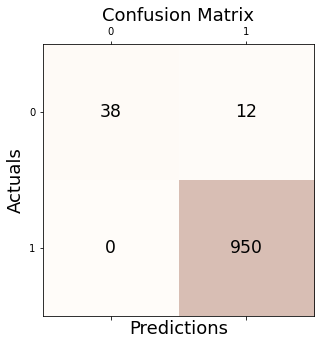

Accuracy: 0.988
Precision: 0.988
Recall: 1.000
F1 Score: 0.994


In [856]:
_conf.conf("GODE")

In [857]:
one = _conf.tab

### LOF

In [858]:
clf = LocalOutlierFactor(n_neighbors=2)

In [859]:
_conf = Conf_matrx(outlier_true_one_1,clf.fit_predict(X),tab_linear)

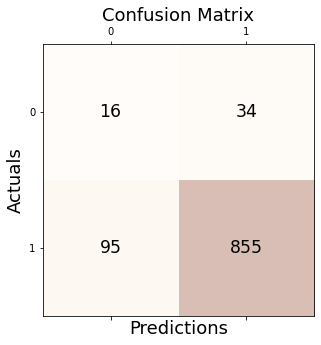

Accuracy: 0.871
Precision: 0.962
Recall: 0.900
F1 Score: 0.930


In [860]:
_conf.conf("LOF")

In [861]:
two = one.append(_conf.tab)

### KNN

In [862]:
from pyod.models.knn import KNN

In [863]:
clf = KNN()
clf.fit(_df[['x', 'y']])
_df['knn_Clf'] = clf.labels_

In [864]:
outlier_KNN_one = list(clf.labels_)

In [865]:
outlier_KNN_one = list(map(lambda x: 1 if x==0  else -1,outlier_KNN_one))

In [866]:
_conf = Conf_matrx(outlier_true_one_1,outlier_KNN_one,tab_linear)

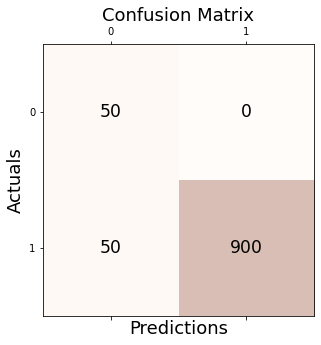

Accuracy: 0.950
Precision: 1.000
Recall: 0.947
F1 Score: 0.973


In [867]:
_conf.conf("KNN")

In [868]:
three = two.append(_conf.tab)

### CBLOF

In [869]:
clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
clf.fit(_df[['x', 'y']])
_df['CBLOF_Clf'] = clf.labels_

In [870]:
outlier_CBLOF_one = list(clf.labels_)

In [871]:
outlier_CBLOF_one = list(map(lambda x: 1 if x==0  else -1,outlier_CBLOF_one))

In [872]:
_conf = Conf_matrx(outlier_true_one_1,outlier_CBLOF_one,tab_linear)

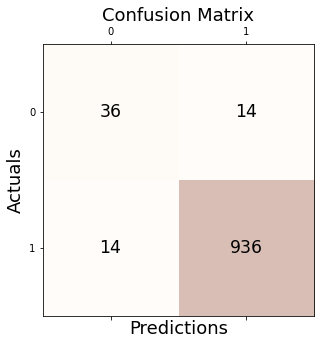

Accuracy: 0.972
Precision: 0.985
Recall: 0.985
F1 Score: 0.985


In [873]:
_conf.conf("CBLOF")

In [874]:
four = three.append(_conf.tab)

### OCSVM

In [875]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [876]:
clf.fit(X)

OneClassSVM(gamma=0.1, nu=0.1)

In [877]:
outlier_OSVM_one = list(clf.predict(X))

In [878]:
_conf = Conf_matrx(outlier_true_one_1,outlier_OSVM_one,tab_linear)

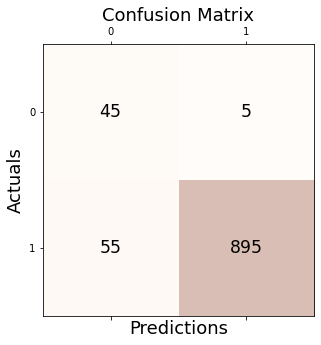

Accuracy: 0.940
Precision: 0.994
Recall: 0.942
F1 Score: 0.968


In [879]:
_conf.conf("OCSVM")

In [880]:
five = four.append(_conf.tab)

### MCD

In [881]:
clf = MCD()
clf.fit(_df[['x', 'y']])
_df['MCD_clf'] = clf.labels_

In [882]:
outlier_MCD_one = list(clf.labels_)

In [883]:
outlier_MCD_one = list(map(lambda x: 1 if x==0  else -1,outlier_MCD_one))

In [884]:
_conf = Conf_matrx(outlier_true_one_1,outlier_MCD_one,tab_linear)

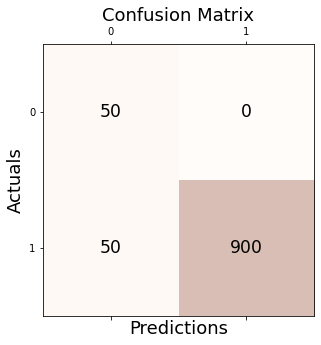

Accuracy: 0.950
Precision: 1.000
Recall: 0.947
F1 Score: 0.973


In [885]:
_conf.conf("MCD")

In [886]:
six = five.append(_conf.tab)

### Feature Bagging

In [887]:
clf = FeatureBagging()
clf.fit(_df[['x', 'y']])
_df['FeatureBagging_clf'] = clf.labels_

In [888]:
outlier_FeatureBagging_one = list(clf.labels_)

In [889]:
outlier_FeatureBagging_one = list(map(lambda x: 1 if x==0  else -1,outlier_FeatureBagging_one))

In [890]:
_conf = Conf_matrx(outlier_true_one_1,outlier_FeatureBagging_one,tab_linear)

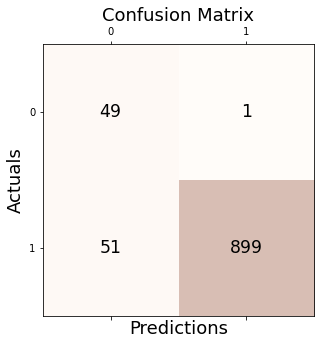

Accuracy: 0.948
Precision: 0.999
Recall: 0.946
F1 Score: 0.972


In [891]:
_conf.conf("Feature Bagging")

In [892]:
seven = six.append(_conf.tab)

### ABOD

In [893]:
clf = ABOD(contamination=0.05)
clf.fit(_df[['x', 'y']])
_df['ABOD_Clf'] = clf.labels_

In [894]:
outlier_ABOD_one = list(clf.labels_)

In [895]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [896]:
_conf = Conf_matrx(outlier_true_one_1,outlier_ABOD_one,tab_linear)

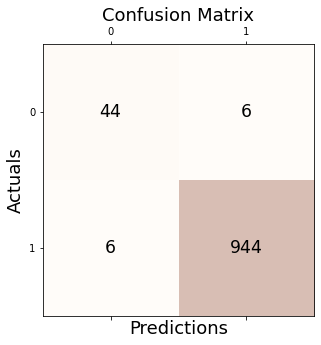

Accuracy: 0.988
Precision: 0.994
Recall: 0.994
F1 Score: 0.994


In [897]:
_conf.conf("ABOD")

In [898]:
eight = seven.append(_conf.tab)

### IForest

In [899]:
od = IForest(
    threshold=0.,
    n_estimators=100
)

In [900]:
od.fit(_df[['x', 'y']])

In [901]:
preds = od.predict(
    _df[['x', 'y']],
    return_instance_score=True
)

In [902]:
_df['IF_alibi'] = preds['data']['is_outlier']

In [903]:
outlier_alibi_one = _df['IF_alibi']

In [904]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [905]:
_conf = Conf_matrx(outlier_true_one_1,outlier_alibi_one,tab_linear)

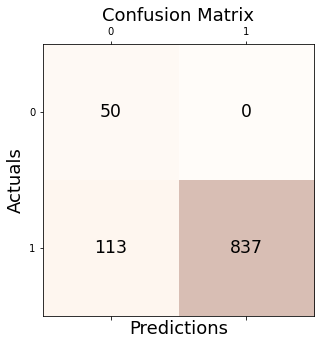

Accuracy: 0.887
Precision: 1.000
Recall: 0.881
F1 Score: 0.937


In [906]:
_conf.conf("IForest")

In [907]:
nine = eight.append(_conf.tab)

### HBOS

In [908]:
clf = HBOS()
clf.fit(_df[['x', 'y']])
_df['HBOS_clf'] = clf.labels_

In [909]:
outlier_HBOS_one = list(clf.labels_)

In [910]:
outlier_HBOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_HBOS_one))

In [911]:
_conf = Conf_matrx(outlier_true_one_1,outlier_HBOS_one,tab_linear)

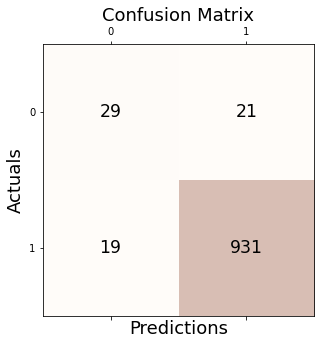

Accuracy: 0.960
Precision: 0.978
Recall: 0.980
F1 Score: 0.979


In [912]:
_conf.conf("HBOS")

In [913]:
ten = nine.append(_conf.tab)

### SOS

In [914]:
outlier_SOS_one = list(clf.labels_)

In [915]:
outlier_SOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_SOS_one))

In [916]:
clf = SOS()
clf.fit(_df[['x', 'y']])
_df['SOS_clf'] = clf.labels_

In [917]:
_conf = Conf_matrx(outlier_true_one_1,outlier_SOS_one,tab_linear)

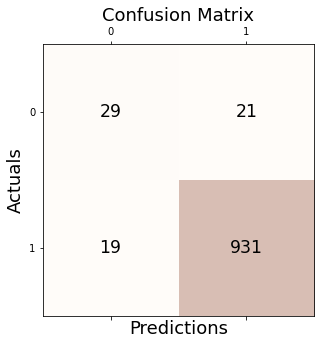

Accuracy: 0.960
Precision: 0.978
Recall: 0.980
F1 Score: 0.979


In [918]:
_conf.conf("SOS")

In [919]:
eleven = ten.append(_conf.tab)

### SO_GAAL

In [920]:
clf = SO_GAAL()
clf.fit(_df[['x', 'y']])
_df['SO_GAAL_clf'] = clf.labels_

Epoch 1 of 60

Testing for epoch 1 index 1:


/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)



Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing for epoch 14 index 1:

Testing for epoch 14 in

In [921]:
outlier_SO_GAAL_one = list(clf.labels_)

In [922]:
outlier_SO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_SO_GAAL_one))

In [923]:
_conf = Conf_matrx(outlier_true_one_1,outlier_SO_GAAL_one,tab_linear)

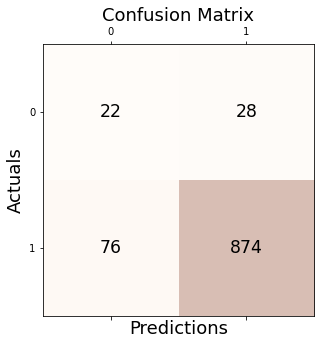

Accuracy: 0.896
Precision: 0.969
Recall: 0.920
F1 Score: 0.944


In [924]:
_conf.conf("SO_GAAL")

In [925]:
twelve = eleven.append(_conf.tab)

### MO_GAAL

In [926]:
clf = MO_GAAL()
clf.fit(_df[['x', 'y']])
_df['MO_GAAL_clf'] = clf.labels_

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing fo

In [927]:
outlier_MO_GAAL_one = list(clf.labels_)

In [928]:
outlier_MO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_MO_GAAL_one))

In [929]:
_conf = Conf_matrx(outlier_true_one_1,outlier_MO_GAAL_one,tab_linear)

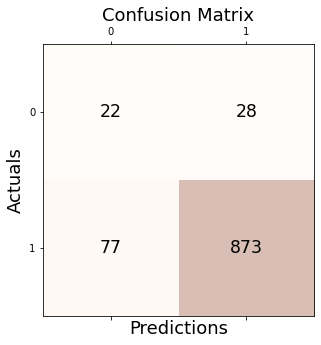

Accuracy: 0.895
Precision: 0.969
Recall: 0.919
F1 Score: 0.943


In [930]:
_conf.conf("MO_GAAL")

In [931]:
thirteen = twelve.append(_conf.tab)

### LSCP

In [932]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors)
clf.fit(_df[['x', 'y']])
_df['LSCP_clf'] = clf.labels_

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(


In [933]:
outlier_LSCP_one = list(clf.labels_)

In [934]:
outlier_LSCP_one = list(map(lambda x: 1 if x==0  else -1,outlier_LSCP_one))

In [935]:
_conf = Conf_matrx(outlier_true_one_1,outlier_LSCP_one,tab_linear)

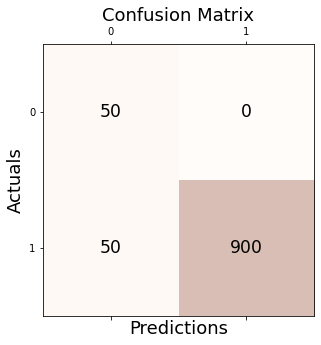

Accuracy: 0.950
Precision: 1.000
Recall: 0.947
F1 Score: 0.973


In [936]:
_conf.conf("LSPC")

In [937]:
fourteen_linear = thirteen.append(_conf.tab)

## Linear Result

In [938]:
round(fourteen_linear,3)

,Accuracy,Precision,Recall,F1
GODE,0.988,0.988,1.000,0.994
LOF,0.871,0.962,0.900,0.930
KNN,0.950,1.000,0.947,0.973
CBLOF,0.972,0.985,0.985,0.985
OCSVM,0.940,0.994,0.942,0.968
MCD,0.950,1.000,0.947,0.973
Feature Bagging,0.948,0.999,0.946,0.972
ABOD,0.988,0.994,0.994,0.994
IForest,0.887,1.000,0.881,0.937
HBOS,0.960,0.978,0.980,0.979


## Orbit EbayesThresh

In [108]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


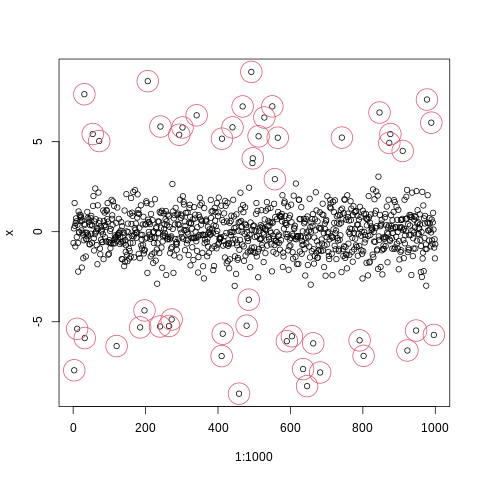

In [109]:
%%R
library(EbayesThresh)
set.seed(1)
epsilon = rnorm(1000)
signal = sample(c(runif(25,-7,-5), runif(25,5,7), rep(0,950)))
index_of_trueoutlier = which(signal!=0)
index_of_trueoutlier
x=signal+epsilon
plot(1:1000,x)
points(index_of_trueoutlier,x[index_of_trueoutlier],col=2,cex=4)

#plot(x,type='l')
#mu <- EbayesThresh::ebayesthresh(x,sdev=2)
#lines(mu,col=2,lty=2,lwd=2)

In [110]:
%R -o x
%R -o index_of_trueoutlier
%R -o signal

In [111]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [112]:
xhat = np.array(ebayesthresh(FloatVector(x)))

In [113]:
# plt.plot(x)
# plt.plot(xhat)

In [114]:
outlier_true_index = index_of_trueoutlier

In [115]:
outlier_true_value = x[index_of_trueoutlier]

package와 비교를 위해 outlier는 -1, inlier는 1로 표시

In [116]:
outlier_true_one = signal.copy()

In [117]:
outlier_true_one = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one))

## Orbit

In [118]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=5+np.cos(np.linspace(0,12*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,6*pi,n))
f = f1 + x

In [119]:
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})

In [120]:
X = np.array(_df)

### GODE

In [121]:
_Orbit = Orbit(_df)

In [122]:
_Orbit.get_distance()

100%|██████████| 1000/1000 [00:02<00:00, 475.61it/s]


In [123]:
_Orbit.get_weightmatrix(theta=(_Orbit.D[_Orbit.D>0].mean()),kappa=2500) 

In [124]:
_Orbit.fit(sd=15,ref=20)

In [125]:
outlier_simul_one = (_Orbit.df['Residual']**2).tolist()

In [126]:
outlier_simul_one = list(map(lambda x: -1 if x > 20 else 1,outlier_simul_one))

In [127]:
_conf = Conf_matrx(outlier_true_one,outlier_simul_one,tab_orbit)

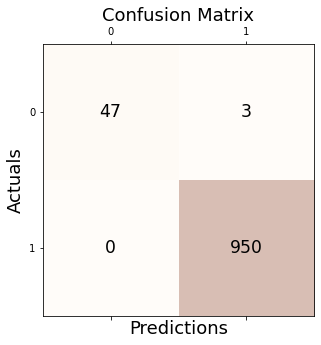

Accuracy: 0.997
Precision: 0.997
Recall: 1.000
F1 Score: 0.998


In [128]:
_conf.conf("GODE")

In [129]:
one = _conf.tab

### LOF

In [130]:
clf = LocalOutlierFactor(n_neighbors=2)

In [131]:
_conf = Conf_matrx(outlier_true_one,clf.fit_predict(X),tab_orbit)

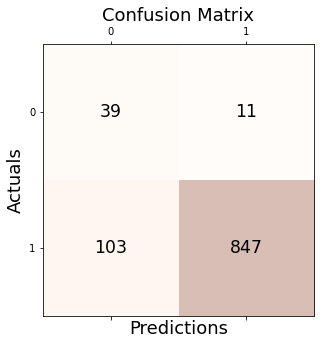

Accuracy: 0.886
Precision: 0.987
Recall: 0.892
F1 Score: 0.937


In [132]:
_conf.conf("LOF")

In [133]:
two = one.append(_conf.tab)

### KNN

In [134]:
clf = KNN()
clf.fit(_df[['x', 'y','f']])
_df['knn_clf'] = clf.labels_

In [135]:
outlier_KNN_one = list(clf.labels_)

In [136]:
outlier_KNN_one = list(map(lambda x: 1 if x==0  else -1,outlier_KNN_one))

In [137]:
_conf = Conf_matrx(outlier_true_one,outlier_KNN_one,tab_orbit)

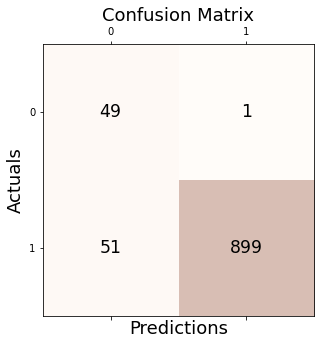

Accuracy: 0.948
Precision: 0.999
Recall: 0.946
F1 Score: 0.972


In [138]:
_conf.conf("KNN")

In [139]:
three = two.append(_conf.tab)

### CBLOF

In [140]:
clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
clf.fit(_df[['x', 'y','f']])
_df['CBLOF_Clf'] = clf.labels_

In [141]:
outlier_CBLOF_one = list(clf.labels_)

In [142]:
outlier_CBLOF_one = list(map(lambda x: 1 if x==0  else -1,outlier_CBLOF_one))

In [143]:
_conf = Conf_matrx(outlier_true_one,outlier_CBLOF_one,tab_orbit)

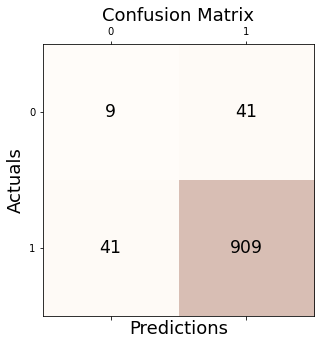

Accuracy: 0.918
Precision: 0.957
Recall: 0.957
F1 Score: 0.957


In [144]:
_conf.conf("CBLOF")

In [145]:
four = three.append(_conf.tab)

### OCSVM

In [146]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [147]:
clf.fit(X)

OneClassSVM(gamma=0.1, nu=0.1)

In [148]:
outlier_OSVM_one = list(clf.predict(X))

In [149]:
_conf = Conf_matrx(outlier_true_one,outlier_OSVM_one,tab_orbit)

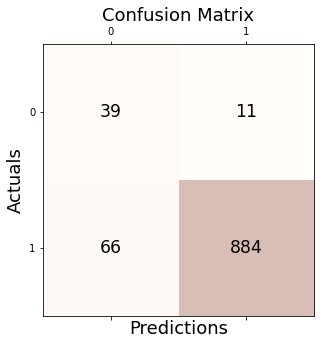

Accuracy: 0.923
Precision: 0.988
Recall: 0.931
F1 Score: 0.958


In [150]:
_conf.conf("OCSVM")

In [151]:
five = four.append(_conf.tab)

### MCD

In [152]:
clf = MCD()
clf.fit(_df[['x', 'y','f']])
_df['MCD_clf'] = clf.labels_

In [153]:
outlier_MCD_one = list(clf.labels_)

In [154]:
outlier_MCD_one = list(map(lambda x: 1 if x==0  else -1,outlier_MCD_one))

In [155]:
_conf = Conf_matrx(outlier_true_one,outlier_MCD_one,tab_orbit)

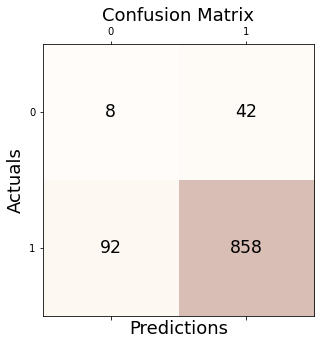

Accuracy: 0.866
Precision: 0.953
Recall: 0.903
F1 Score: 0.928


In [156]:
_conf.conf("MCD")

In [157]:
six = five.append(_conf.tab)

### Feature Bagging

In [158]:
clf = FeatureBagging()
clf.fit(_df[['x', 'y','f']])
_df['FeatureBagging_clf'] = clf.labels_

In [159]:
outlier_FeatureBagging_one = list(clf.labels_)

In [160]:
outlier_FeatureBagging_one = list(map(lambda x: 1 if x==0  else -1,outlier_FeatureBagging_one))

In [161]:
_conf = Conf_matrx(outlier_true_one,outlier_FeatureBagging_one,tab_orbit)

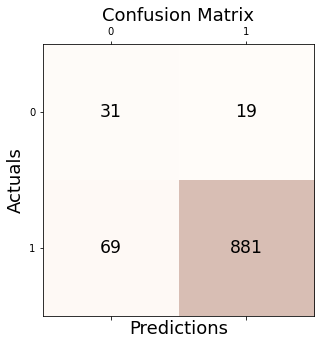

Accuracy: 0.912
Precision: 0.979
Recall: 0.927
F1 Score: 0.952


In [162]:
_conf.conf("Feature Bagging")

In [163]:
seven = six.append(_conf.tab)

### ABOD

In [164]:
clf = ABOD(contamination=0.05)
clf.fit(_df[['x', 'y','f']])
_df['ABOD_Clf'] = clf.labels_

In [165]:
outlier_ABOD_one = list(clf.labels_)

In [166]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [167]:
_conf = Conf_matrx(outlier_true_one,outlier_ABOD_one,tab_orbit)

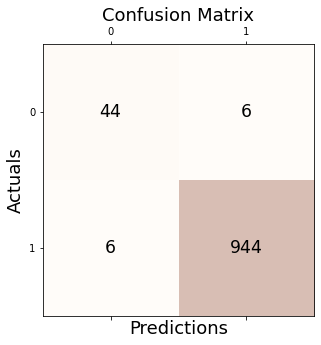

Accuracy: 0.988
Precision: 0.994
Recall: 0.994
F1 Score: 0.994


In [168]:
_conf.conf("ABOD")

In [169]:
eight = seven.append(_conf.tab)

### IForest

In [170]:
od = IForest(
    threshold=0.,
    n_estimators=100
)

In [171]:
od.fit(_df[['x', 'y','f']])

In [172]:
preds = od.predict(
    _df[['x', 'y','f']],
    return_instance_score=True
)

In [173]:
_df['IF_alibi'] = preds['data']['is_outlier']

In [174]:
outlier_alibi_one = _df['IF_alibi']

In [175]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [176]:
_conf = Conf_matrx(outlier_true_one,outlier_alibi_one,tab_orbit)

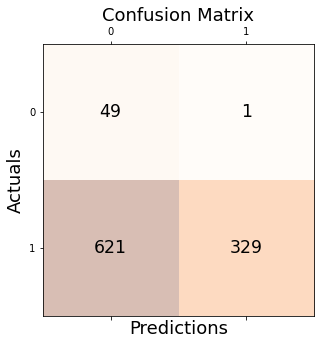

Accuracy: 0.378
Precision: 0.997
Recall: 0.346
F1 Score: 0.514


In [177]:
_conf.conf("IForest")

In [178]:
nine = eight.append(_conf.tab)

### HBOS

In [179]:
clf = HBOS()
clf.fit(_df[['x', 'y','f']])
_df['HBOS_clf'] = clf.labels_

In [180]:
outlier_HBOS_one = list(clf.labels_)

In [181]:
outlier_HBOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_HBOS_one))

In [182]:
_conf = Conf_matrx(outlier_true_one,outlier_HBOS_one,tab_orbit)

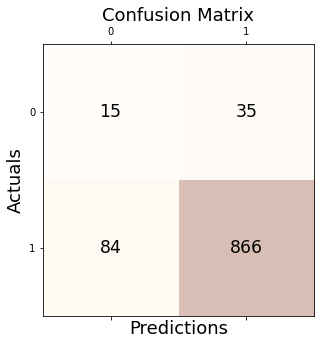

Accuracy: 0.881
Precision: 0.961
Recall: 0.912
F1 Score: 0.936


In [183]:
_conf.conf("HBOS")

In [184]:
ten = nine.append(_conf.tab)

### SOS

In [185]:
outlier_SOS_one = list(clf.labels_)

In [186]:
outlier_SOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_SOS_one))

In [187]:
clf = SOS()
clf.fit(_df[['x', 'y','f']])
_df['SOS_clf'] = clf.labels_

In [188]:
_conf = Conf_matrx(outlier_true_one,outlier_SOS_one,tab_orbit)

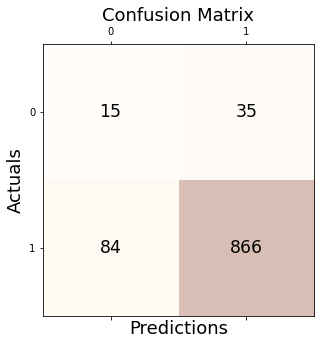

Accuracy: 0.881
Precision: 0.961
Recall: 0.912
F1 Score: 0.936


In [189]:
_conf.conf("SOS")

In [190]:
eleven = ten.append(_conf.tab)

### SO_GAAL

In [191]:
clf = SO_GAAL()
clf.fit(_df[['x', 'y','f']])
_df['SO_GAAL_clf'] = clf.labels_

Epoch 1 of 60

Testing for epoch 1 index 1:


/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)



Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing for epoch 14 index 1:

Testing for epoch 14 in

In [192]:
outlier_SO_GAAL_one = list(clf.labels_)

In [193]:
outlier_SO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_SO_GAAL_one))

In [194]:
_conf = Conf_matrx(outlier_true_one,outlier_SO_GAAL_one,tab_orbit)

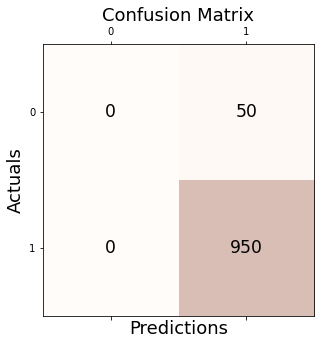

Accuracy: 0.950
Precision: 0.950
Recall: 1.000
F1 Score: 0.974


In [195]:
_conf.conf("SO_GAAL")

In [196]:
twelve = eleven.append(_conf.tab)

### MO_GAAL

In [197]:
clf = MO_GAAL()
clf.fit(_df[['x', 'y','f']])
_df['MO_GAAL_clf'] = clf.labels_

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing fo

In [198]:
outlier_MO_GAAL_one = list(clf.labels_)

In [199]:
outlier_MO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_MO_GAAL_one))

In [200]:
_conf = Conf_matrx(outlier_true_one,outlier_MO_GAAL_one,tab_orbit)

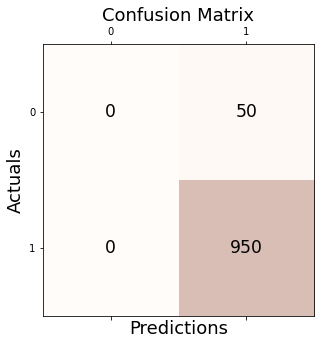

Accuracy: 0.950
Precision: 0.950
Recall: 1.000
F1 Score: 0.974


In [201]:
_conf.conf("MO_GAAL")

In [202]:
thirteen = twelve.append(_conf.tab)

### LSCP

In [203]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors)
clf.fit(_df[['x', 'y','f']])
_df['LSCP_clf'] = clf.labels_

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(


In [204]:
outlier_LSCP_one = list(clf.labels_)

In [205]:
outlier_LSCP_one = list(map(lambda x: 1 if x==0  else -1,outlier_LSCP_one))

In [206]:
_conf = Conf_matrx(outlier_true_one,outlier_LSCP_one,tab_orbit)

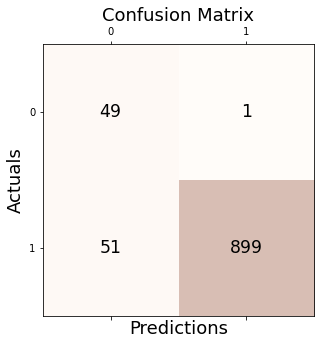

Accuracy: 0.948
Precision: 0.999
Recall: 0.946
F1 Score: 0.972


In [207]:
_conf.conf("LSCP")

In [208]:
fourteen_orbit = thirteen.append(_conf.tab)

## Orbit Result

In [209]:
round(fourteen_orbit,4)

,Accuracy,Precision,Recall,F1
GODE,0.997,0.9969,1.0000,0.9984
LOF,0.886,0.9872,0.8916,0.9369
KNN,0.948,0.9989,0.9463,0.9719
CBLOF,0.918,0.9568,0.9568,0.9568
OCSVM,0.923,0.9877,0.9305,0.9583
MCD,0.866,0.9533,0.9032,0.9276
Feature Bagging,0.912,0.9789,0.9274,0.9524
ABOD,0.988,0.9937,0.9937,0.9937
IForest,0.378,0.9970,0.3463,0.5141
HBOS,0.881,0.9612,0.9116,0.9357


## Bunny

In [210]:
G = graphs.Bunny()
n = G.N

In [211]:
g = filters.Heat(G, tau=75) 

In [212]:
normal = np.random.randn(n)
unif = np.concatenate([np.random.uniform(low=3,high=7,size=60), np.random.uniform(low=-7,high=-3,size=60),np.zeros(n-120)]); np.random.shuffle(unif)
noise = normal + unif
index_of_trueoutlier2 = np.where(unif!=0)

In [213]:
f = np.zeros(n)
f[1000] = -3234
f = g.filter(f, method='chebyshev') 

2022-11-20 14:53:12,309:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


In [592]:
G.coords.shape

(2503, 3)

In [214]:
_W = G.W.toarray()
_x = G.coords[:,0]
_y = G.coords[:,1]
_z = -G.coords[:,2]

In [215]:
_df = pd.DataFrame({'x' : _x, 'y' : _y, 'z' : _z, 'fnoise':f+noise,'f' : f, 'noise': noise})

In [216]:
outlier_true_one_2 = unif.copy()

In [217]:
outlier_true_one_2 = list(map(lambda x: -1 if x !=0  else 1,outlier_true_one_2))

In [218]:
X = np.array(_df)[:,:4]

### GODE

In [219]:
_BUNNY = BUNNY(_df)

In [220]:
_BUNNY.fit(sd=20,ref=10)

In [221]:
outlier_simul_one = (_BUNNY.df['Residual']**2).tolist()

In [222]:
outlier_simul_one = list(map(lambda x: -1 if x > 10 else 1,outlier_simul_one))

In [223]:
_conf = Conf_matrx(outlier_true_one_2,outlier_simul_one,tab_bunny)

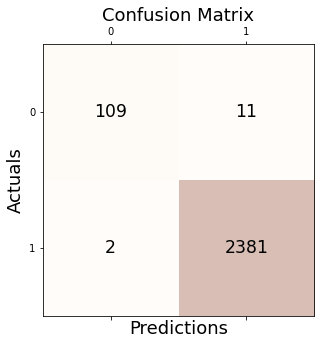

Accuracy: 0.995
Precision: 0.995
Recall: 0.999
F1 Score: 0.997


In [224]:
_conf.conf("GODE")

In [225]:
one = _conf.tab

### LOF

In [226]:
clf = LocalOutlierFactor(n_neighbors=2)

In [227]:
_conf = Conf_matrx(outlier_true_one_2,clf.fit_predict(X),tab_bunny)

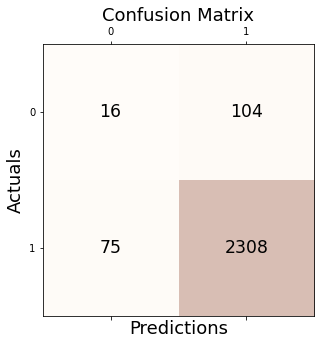

Accuracy: 0.928
Precision: 0.957
Recall: 0.969
F1 Score: 0.963


In [228]:
_conf.conf("LOF")

In [229]:
two = one.append(_conf.tab)

### KNN

In [230]:
clf = KNN()
clf.fit(_df[['x', 'y','fnoise']])
_df['knn_Clf'] = clf.labels_

In [231]:
outlier_KNN_one = list(clf.labels_)

In [232]:
outlier_KNN_one = list(map(lambda x: 1 if x==0  else -1,outlier_KNN_one))

In [233]:
_conf = Conf_matrx(outlier_true_one_2,outlier_KNN_one,tab_bunny)

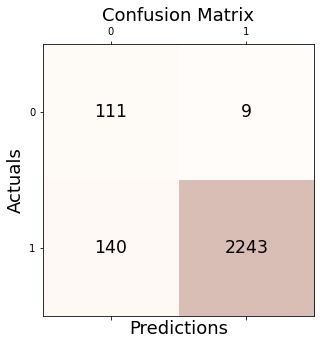

Accuracy: 0.940
Precision: 0.996
Recall: 0.941
F1 Score: 0.968


In [234]:
_conf.conf("KNN")

In [235]:
three = two.append(_conf.tab)

### CBLOF

In [236]:
clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
clf.fit(_df[['x', 'y','fnoise']])
_df['CBLOF_Clf'] = clf.labels_

In [237]:
outlier_CBLOF_one = list(clf.labels_)

In [238]:
outlier_CBLOF_one = list(map(lambda x: 1 if x==0  else -1,outlier_CBLOF_one))

In [239]:
_conf = Conf_matrx(outlier_true_one_2,outlier_CBLOF_one,tab_bunny)

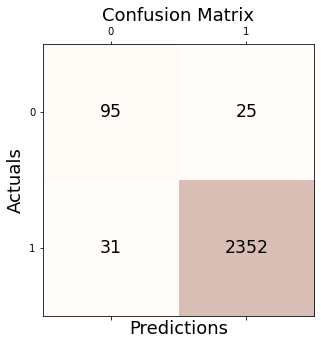

Accuracy: 0.978
Precision: 0.989
Recall: 0.987
F1 Score: 0.988


In [240]:
_conf.conf("CBLOF")

In [241]:
four = three.append(_conf.tab)

### OCSVM

In [242]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [243]:
clf.fit(X)

OneClassSVM(gamma=0.1, nu=0.1)

In [244]:
outlier_OSVM_one = list(clf.predict(X))

In [245]:
_conf = Conf_matrx(outlier_true_one_2,outlier_OSVM_one,tab_bunny)

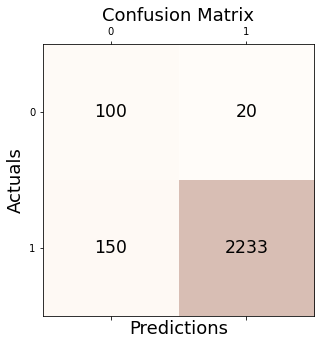

Accuracy: 0.932
Precision: 0.991
Recall: 0.937
F1 Score: 0.963


In [246]:
_conf.conf("OCSVM")

In [247]:
five = four.append(_conf.tab)

### MCD

In [248]:
clf = MCD()
clf.fit(_df[['x', 'y','fnoise']])
_df['MCD_clf'] = clf.labels_

In [249]:
outlier_MCD_one = list(clf.labels_)

In [250]:
outlier_MCD_one = list(map(lambda x: 1 if x==0  else -1,outlier_MCD_one))

In [251]:
_conf = Conf_matrx(outlier_true_one_2,outlier_MCD_one,tab_bunny)

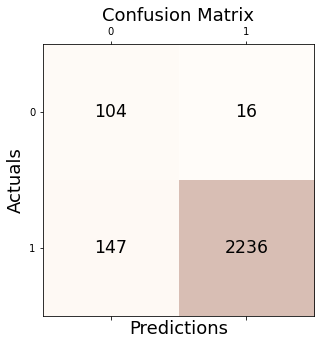

Accuracy: 0.935
Precision: 0.993
Recall: 0.938
F1 Score: 0.965


In [252]:
_conf.conf("MCD")

In [253]:
six = five.append(_conf.tab)

### Feature Bagging

In [254]:
clf = FeatureBagging()
clf.fit(_df[['x', 'y','fnoise']])
_df['FeatureBagging_clf'] = clf.labels_

In [255]:
outlier_FeatureBagging_one = list(clf.labels_)

In [256]:
outlier_FeatureBagging_one = list(map(lambda x: 1 if x==0  else -1,outlier_FeatureBagging_one))

In [257]:
_conf = Conf_matrx(outlier_true_one_2,outlier_FeatureBagging_one,tab_bunny)

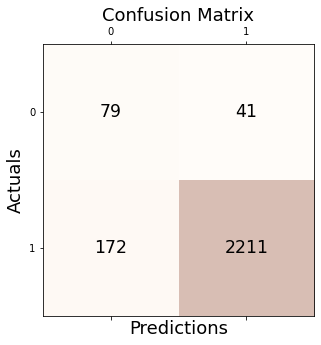

Accuracy: 0.915
Precision: 0.982
Recall: 0.928
F1 Score: 0.954


In [258]:
_conf.conf("Feature Bagging")

In [259]:
seven = six.append(_conf.tab)

### ABOD

In [260]:
clf = ABOD(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])
_df['ABOD_Clf'] = clf.labels_

In [261]:
outlier_ABOD_one = list(clf.labels_)

In [262]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [263]:
_conf = Conf_matrx(outlier_true_one_2,outlier_ABOD_one,tab_bunny)

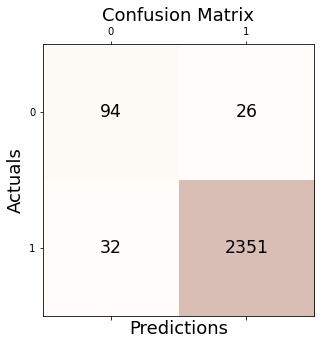

Accuracy: 0.977
Precision: 0.989
Recall: 0.987
F1 Score: 0.988


In [264]:
_conf.conf("ABOD")

In [265]:
eight = seven.append(_conf.tab)

### IForest

In [266]:
od = IForest(
    threshold=0.,
    n_estimators=100
)

In [267]:
od.fit(_df[['x', 'y','fnoise']])

In [268]:
preds = od.predict(
    _df[['x', 'y','fnoise']],
    return_instance_score=True
)

In [269]:
_df['IF_alibi'] = preds['data']['is_outlier']

In [270]:
outlier_alibi_one = _df['IF_alibi']

In [271]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [272]:
_conf = Conf_matrx(outlier_true_one_2,outlier_alibi_one,tab_bunny)

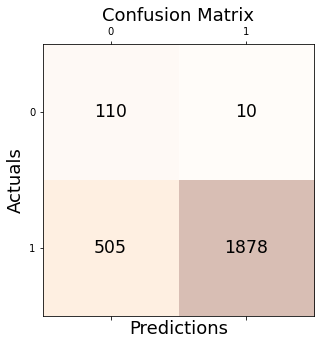

Accuracy: 0.794
Precision: 0.995
Recall: 0.788
F1 Score: 0.879


In [273]:
_conf.conf("IForest")

In [274]:
nine = eight.append(_conf.tab)

### HBOS

In [275]:
clf = HBOS()
clf.fit(_df[['x', 'y','fnoise']])
_df['HBOS_clf'] = clf.labels_

In [276]:
outlier_HBOS_one = list(clf.labels_)

In [277]:
outlier_HBOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_HBOS_one))

In [278]:
_conf = Conf_matrx(outlier_true_one_2,outlier_HBOS_one,tab_bunny)

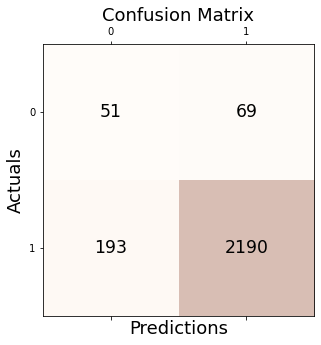

Accuracy: 0.895
Precision: 0.969
Recall: 0.919
F1 Score: 0.944


In [279]:
_conf.conf("HBOS")

In [280]:
ten = nine.append(_conf.tab)

### SOS

In [281]:
outlier_SOS_one = list(clf.labels_)

In [282]:
outlier_SOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_SOS_one))

In [283]:
clf = SOS()
clf.fit(_df[['x', 'y','fnoise']])
_df['SOS_clf'] = clf.labels_

In [284]:
_conf = Conf_matrx(outlier_true_one_2,outlier_SOS_one,tab_bunny)

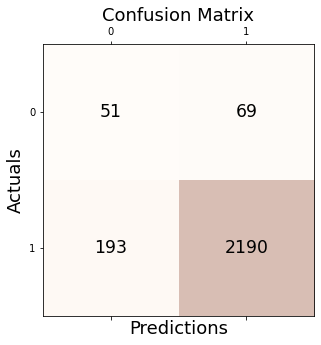

Accuracy: 0.895
Precision: 0.969
Recall: 0.919
F1 Score: 0.944


In [285]:
_conf.conf("SOS")

In [286]:
eleven = ten.append(_conf.tab)

### SO_GAAL

In [287]:
clf = SO_GAAL()
clf.fit(_df[['x', 'y','fnoise']])
_df['SO_GAAL_clf'] = clf.labels_

Epoch 1 of 60

Testing for epoch 1 index 1:


/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)



Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:

Testing for epoch 2 index 4:

Testing for epoch 2 index 5:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:

Testing for epoch 3 index 4:

Testing for epoch 3 index 5:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:

Testing for epoch 4 index 3:

Testing for epoch 4 index 4:

Testing for epoch 4 index 5:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:

Testing for epoch 5 index 3:

Testing for epoch 5 index 4:

Testing for epoch 5 index 5:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:

Testing for epoch 6 index 3:

Testing for epoch 6 index 4:

Testing for epoch 6 index 5:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epo

In [288]:
outlier_SO_GAAL_one = list(clf.labels_)

In [289]:
outlier_SO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_SO_GAAL_one))

In [290]:
_conf = Conf_matrx(outlier_true_one_2,outlier_SO_GAAL_one,tab_bunny)

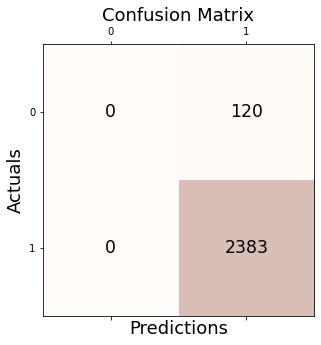

Accuracy: 0.952
Precision: 0.952
Recall: 1.000
F1 Score: 0.975


In [291]:
_conf.conf("SO_GAAL")

In [292]:
twelve = eleven.append(_conf.tab)

### MO_GAAL

In [293]:
clf = MO_GAAL()
clf.fit(_df[['x', 'y','fnoise']])
_df['MO_GAAL_clf'] = clf.labels_

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:

Testing for epoch 2 index 4:

Testing for epoch 2 index 5:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:

Testing for epoch 3 index 4:

Testing for epoch 3 index 5:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:

Testing for epoch 4 index 3:

Testing for epoch 4 index 4:

Testing for epoch 4 index 5:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:

Testing for epoch 5 index 3:

Testing for epoch 5 index 4:

Testing for epoch 5 index 5:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:

Testing for epoch 6 index 3:

Testing for epoch 6 index 4:

Testing for epoch 6 index 5:
Epoch 7 of 60

T

In [294]:
outlier_MO_GAAL_one = list(clf.labels_)

In [295]:
outlier_MO_GAAL_one = list(map(lambda x: 1 if x==0  else -1,outlier_MO_GAAL_one))

In [296]:
_conf = Conf_matrx(outlier_true_one_2,outlier_MO_GAAL_one,tab_bunny)

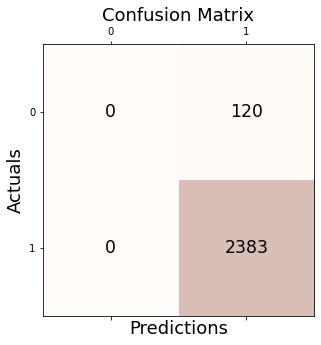

Accuracy: 0.952
Precision: 0.952
Recall: 1.000
F1 Score: 0.975


In [297]:
_conf.conf("MO_GAAL")

In [298]:
thirteen = twelve.append(_conf.tab)

### LSCP

In [299]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors)
clf.fit(_df[['x', 'y','fnoise']])
_df['LSCP_clf'] = clf.labels_

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(


In [300]:
outlier_LSCP_one = list(clf.labels_)

In [301]:
outlier_LSCP_one = list(map(lambda x: 1 if x==0  else -1,outlier_LSCP_one))

In [302]:
_conf = Conf_matrx(outlier_true_one_2,outlier_LSCP_one,tab_bunny)

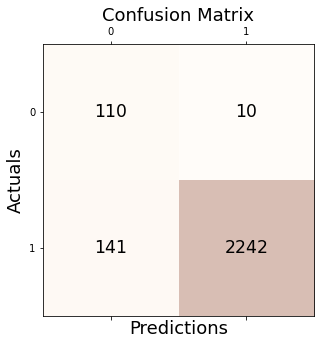

Accuracy: 0.940
Precision: 0.996
Recall: 0.941
F1 Score: 0.967


In [303]:
_conf.conf("LSCP")

In [304]:
fourteen_bunny = thirteen.append(_conf.tab)

## Bunny Result

In [305]:
round(fourteen_bunny,4)

,Accuracy,Precision,Recall,F1
GODE,0.9948,0.9954,0.9992,0.9973
LOF,0.9285,0.9569,0.9685,0.9627
KNN,0.9405,0.9960,0.9413,0.9679
CBLOF,0.9776,0.9895,0.9870,0.9882
OCSVM,0.9321,0.9911,0.9371,0.9633
MCD,0.9349,0.9929,0.9383,0.9648
Feature Bagging,0.9149,0.9818,0.9278,0.9540
ABOD,0.9768,0.9891,0.9866,0.9878
IForest,0.7942,0.9947,0.7881,0.8794
HBOS,0.8953,0.9695,0.9190,0.9436
